In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [3]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [4]:
df = pd.read_json("archive/News_Category_Dataset_v2.json",lines=True)

In [5]:
df.shape

(200853, 6)

In [6]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [7]:
df['category'].describe()

count       200853
unique          41
top       POLITICS
freq         32739
Name: category, dtype: object

In [8]:
df['category'].value_counts(ascending=False).head(10)

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
Name: category, dtype: int64

In [9]:
#I am taking top 10 categories based on count
df_top_10_category = df[df.category.isin(df.category.value_counts(ascending=False).head(10).index)]

In [11]:
df_top_10_category['news'] = df_top_10_category['headline'] + ' ' + df_top_10_category['short_description']

<AxesSubplot:title={'center':'Percentage of categories'}, ylabel='category'>

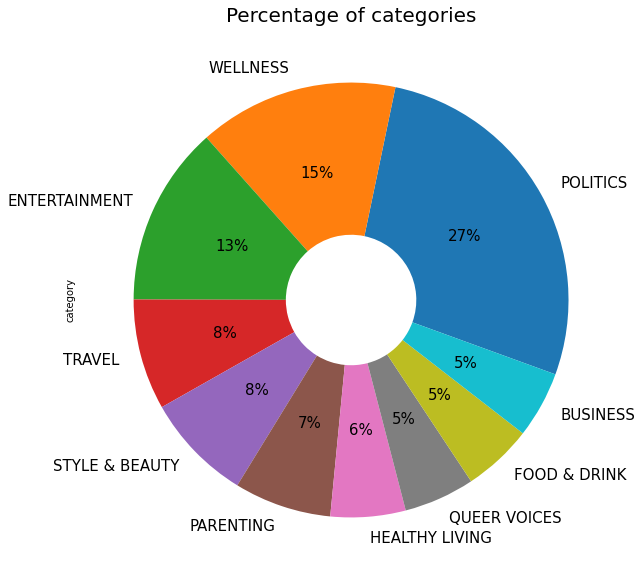

In [12]:
plt.figure(figsize=(30,10))
plt.title('Percentage of categories', fontsize=20)
df_top_10_category.category.value_counts(ascending=False).plot(kind='pie', labels=list(df_top_10_category['category'].value_counts(ascending=False).index),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

In [13]:
print(df_top_10_category.isnull().sum())

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
news                 0
dtype: int64


## Removing the stopwords

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
def plot_top_n_words(corpus,title=None,n=None):
    common_words = get_top_n_words(corpus,n)
    df4 = pd.DataFrame(common_words, columns = ['news' , 'count'])
    df4.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title=title)

## Plot for words occurrence

In [15]:
plot_top_n_words(df_top_10_category['news'],title='Top 10 words in news',n=10)

In [16]:
plot_top_n_words(df_top_10_category['news'],title='Top 10 words in news',n=10)

In [17]:
plot_top_n_words(df_top_10_category[df_top_10_category['category'] == 'POLITICS']['news'],title='Top 10 words in news for politics',n=10)

In [18]:
plot_top_n_words(df_top_10_category[df_top_10_category['category'] == 'WELLNESS']['news'],title='Top 10 words in news for wellness',n=10)

In [19]:
plot_top_n_words(df_top_10_category[df_top_10_category['category'] == 'ENTERTAINMENT']['news'],title='Top 10 words in news for entertaimment',n=10)

## Plot for bigrams

In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
def plot_top_n_bigram(corpus,title=None,n=None):
    common_words = get_top_n_bigram(corpus,n)
    df4 = pd.DataFrame(common_words, columns = ['news' , 'count'])
    df4.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title=title)

In [21]:
plot_top_n_bigram(df_top_10_category['news'],title='Top 10 bigrams in news',n=10)

In [22]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'POLITICS']['news'],title='Top 10 bigrams in news for politics',n=10)

In [23]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'WELLNESS']['news'],title='Top 10 bigrams in news for wellness',n=10)

In [24]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'ENTERTAINMENT']['news'],title='Top 10 bigrams in news for entertainment',n=10)

## Bigrams makes more sense so let us plot for all other categories also

In [25]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'TRAVEL']['news'],title='Top 10 bigrams in news for travel',n=10)

In [26]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'STYLE & BEAUTY']['news'],title='Top 10 bigrams in news for style & beauty',n=10)

In [27]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'PARENTING']['news'],title='Top 10 bigrams in news for parenting',n=10)

In [28]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'HEALTHY LIVING']['news'],title='Top 10 bigrams in news for healthy living',n=10)

In [29]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'QUEER VOICES']['news'],title='Top 10 bigrams in news for queer voices',n=10)

In [30]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'FOOD & DRINK']['news'],title='Top 10 bigrams in news for food & drink',n=10)

In [31]:
plot_top_n_bigram(df_top_10_category[df_top_10_category['category'] == 'BUSINESS']['news'],title='Top 10 bigrams in news for business',n=10)

## Preparing for the model training

In [32]:
#split the train and test dataset
X_train,X_test,y_train,y_test = train_test_split(df_top_10_category['news'],df_top_10_category['category'],test_size = 0.1,random_state=2)

In [33]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [34]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [35]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [36]:
def classifier_scores(y_train,y_test, pred_train, pred_test):
    
    print()
    print("Train data accuracy score: ", accuracy_score(y_train,pred_train))    
    print("Test data accuracy score: ", accuracy_score(y_test,pred_test))
    print()
    print("Recall score on train data: ", recall_score(y_train,pred_train, average='macro'))
    print("Recall score on test data: ",recall_score( y_test,pred_test, average='macro'))
    print()
    
    print("Precision score on train data: ",precision_score(y_train,pred_train, average='macro'))
    print("Precision score on test data: ",precision_score(y_test,pred_test, average='macro'))
    print()
    print("F1 score on train data: ",f1_score(y_train,pred_train, average='macro'))
    print("F1 score on test data: ",f1_score(y_test,pred_test, average='macro'))

In [37]:
classifier_scores(y_train,y_test, pred_train, pred_test)


Train data accuracy score:  0.6894923477182034
Test data accuracy score:  0.6541121573202233

Recall score on train data:  0.5121028391093151
Recall score on test data:  0.47182403577693394

Precision score on train data:  0.8686980372083786
Precision score on test data:  0.8502148210379298

F1 score on train data:  0.5299057459534259
F1 score on test data:  0.48410456869818885


## Model training after cleansing the news data

In [38]:
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
corpus=[]
n_records = len(df_top_10_category)
for i in range(n_records):
    text = df_top_10_category.iloc[i,1]
    
    text = text.lower()
    text = re.sub('[^a-z0-9]',' ',text)
    text = text.split()
    
    s = PorterStemmer()
    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]
    text = ' '.join(text)
    corpus.append(text)
    
    if i%1000==0:
        print(i,end='->')

0->1000->2000->3000->4000->5000->6000->7000->8000->9000->10000->11000->12000->13000->14000->15000->16000->17000->18000->19000->20000->21000->22000->23000->24000->25000->26000->27000->28000->29000->30000->31000->32000->33000->34000->35000->36000->37000->38000->39000->40000->41000->42000->43000->44000->45000->46000->47000->48000->49000->50000->51000->52000->53000->54000->55000->56000->57000->58000->59000->60000->61000->62000->63000->64000->65000->66000->67000->68000->69000->70000->71000->72000->73000->74000->75000->76000->77000->78000->79000->80000->81000->82000->83000->84000->85000->86000->87000->88000->89000->90000->91000->92000->93000->94000->95000->96000->97000->98000->99000->100000->101000->102000->103000->104000->105000->106000->107000->108000->109000->110000->111000->112000->113000->114000->115000->116000->117000->118000->119000->120000->

In [39]:
df_top_10_category['news_corpus'] = corpus

In [40]:
#split the train and test dataset
X_train,X_test,y_train,y_test = train_test_split(df_top_10_category['news_corpus'],df_top_10_category['category'],test_size = 0.1,random_state=2)

In [41]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [42]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [43]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [44]:
classifier_scores(y_train,y_test, pred_train, pred_test)


Train data accuracy score:  0.720286648087624
Test data accuracy score:  0.6727772685609532

Recall score on train data:  0.5794380468837355
Recall score on test data:  0.5238998641632161

Precision score on train data:  0.8451104692568208
Precision score on test data:  0.7926631701596489

F1 score on train data:  0.6110879355135651
F1 score on test data:  0.5499902440259408


In [45]:
df_test = pd.DataFrame({'news':X_test, 'predicted_category':list(pred_test)})
df_test['actual'] = y_test

In [46]:
df_test

,news,predicted_category,actual
148778,site hitler bunker,POLITICS,TRAVEL
164597,bodi media fit armband review,WELLNESS,WELLNESS
73825,kentucki governor restor vote right nonviol former felon,POLITICS,POLITICS
71224,jeff schaffer talk favorit behind scene moment leagu,ENTERTAINMENT,ENTERTAINMENT
14454,short film remind us world mental health day import,WELLNESS,HEALTHY LIVING
...,...,...,...
123105,unreleas britney spear song kind sultri,ENTERTAINMENT,ENTERTAINMENT
146236,biscuit sandwich recip photo,FOOD & DRINK,FOOD & DRINK
122221,media miss tea parti movement,POLITICS,POLITICS
146326,weep wean challeng extend breastfeed,PARENTING,PARENTING


## References:-
#### https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
#### https://www.kaggle.com/ninjaac/text-classification-newss
#### https://www.kaggle.com/irfanmansuri/news-data
